%%html
<style>
    .exercise {
        background-color: #AFEEEE;
        font-style: normal;
        text-align: justify;
        margin-left: 0px;
        margin-right: 10px;
        margin-top: 10px;
        margin-bottom: 0px;
        display: block;
    }
</style>


<center style="font-size:25px;padding-bottom:10px;">Midterm - Procesos Estocásticos</center>
<center style="font-size:20px;padding-bottom:10px;">Máster en Ciencia de Datos -  Universidad Autónoma de Madrid</center>
<center style="font-size:20px;padding-bottom:10px;">José Antonio Álvarez Ocete</center>

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize, stats
import random
from collections import Counter, defaultdict

<div class="exercise">
<h1>Enunciado</h1>

Consideremos la siguente cadena de Markov:

<img src="figures/chain.png" style="max-width: 40%; height: auto;"/>

(se asuma que en cada estado hay una flecha hasta el mismo estado que hace que la suma de las
probabilidades en salida sea 1), con $p = 0.3$.

$i)$ Determinar la matriz de transición de la cadena.
</div>

Obtenemos la matriz de transición consultando el grafo anterior y colocando en la posición $i,j$ la probabilidad de transición del estado $i$ al $j$. En la diagonal colocamos la probabilidad de mantenernos en el estado $i,i$, siendo esta $1$ menos las la suma de las probabilidades de salir de dicho estado.

$$
    P = 
    \begin{pmatrix}
        1-p & p & 0 & 0 & 0 & 0 \\
        0 & 1-p & p/2 & 0 & p/2 & 0 & \\
        1/4 & 0 & 1/4 & 1/4 & 1/4 & 0 \\
        q & 0 & 0 & 0.9-q & 0.1 & 0 \\
        0 & 0 & 0 & 0 & 1/2 & 1/2 \\
        0 & 0 & 0 & 1/4 & 1/2 & 1/4
    \end{pmatrix}
$$

Como medida de comprobación podemos asegurarnos de que todas las filas sumen $1$, como hacen.

<div class="exercise">

$ii)$ Simular el funcionamiento de la cadena y hacer una estimación de conjunto de $h_0^2$ y $h_0^5$ para $q = 0.1$ y $q = 0$.
</div>

Explicaremos la implementación de la simulación paso a paso. En primer lugar, creamos una función sencilla que, dados $p$ y $q$, devuelve la matriz $P$ de nuestro problema.

A continuación definimos una función 'collapsa' un estado de nuestro sistema a un único $m \in M$. Por ejemplo, dado el estado $\phi = [1/3, 2/3]$:

$$ 
collapse(\phi) = 
\begin{cases}
[1, 0] & \quad \text{with probability} \; 1/3 \\
[0, 1] & \quad \text{with probability} \; 2/3
\end{cases}
$$

Para ello utilizaremos que los vectores de estados han de sumar 1 y aplicaremos el método de la función inversa para elegir a qué estado colapsar. Esto es, la suma acumulativa de los valores del vector y generamos un valor uniformemente en $(0,1)$. Comparamos con los valores de dicha suma acumulativa para ver a qué estado colapsar. Por ejemplo, para el caso anterior:

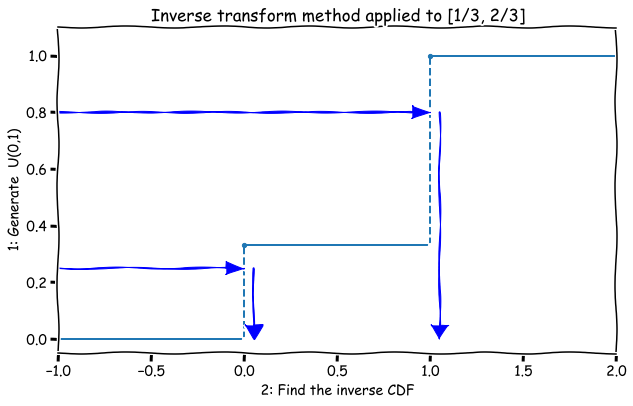

In [31]:
dist = stats.norm
dist_pdf = dist.pdf
dist_icdf = dist.ppf
dist_cdf = dist.cdf

p = 1/3
x = np.array([-1, 0, 1, 2])
y = np.array([p, 1])
yn = np.insert(y, 0, 0)

with plt.xkcd():
    plt.figure(figsize=(10,6))
    plt.hlines(y=yn, xmin=x[:-1], xmax=x[1:], zorder=1)
    plt.vlines(x=x[1:-1], ymin=yn[:-1], ymax=yn[1:], linestyle='dashed', zorder=1)
    
    plt.scatter(x[1:-1], y, s=18, zorder=2)
    plt.scatter(x[1:-1], yn[:-1], color='white', s=18, zorder=2)

    plt.axis([-1, 2, -0.05, 1.1])
    for q, x_pos in zip([0.25, 0.8], x[1:3]):
        plt.arrow(-1, q, 0.9+x_pos, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
        plt.arrow(x_pos+0.05, q, 0, -q+0.05, head_width=0.1, head_length=0.05, fc='b', ec='b')

    plt.ylabel('1: Generate  U(0,1)')
    plt.xlabel('2: Find the inverse CDF')
    plt.title('Inverse transform method applied to [1/3, 2/3]')

Implementamos las funciones descritas.

In [32]:
def get_P(p, q):
    return np.array([[  1-p,    p,    0.0,    0.0,    0.0,    0.0],
                    [  0.0,  1-p,  p/2.0,    0.0,   p/2.0,   0.0],
                    [1/4.0,  0.0,  1/4.0,   1/4.0,  1/4.0,   0.0],
                    [    q,  0.0,    0.0, 1-q-0.1,    0.1,   0.0],
                    [  0.0,  0.0,    0.0,     0.0,  1/2.0, 1/2.0],
                    [  0.0,  0.0,    0.0,    1/4.0, 1/2.0, 1/4.0]
                    ])

def collapse(state):
    """
        Given a state, collapses it to a single position
        with the given probabilities in the state. For example, given:
            state = [1/3, 2/3]
        collapse(state) will output:
        - [1, 0] with probability 1/3
        - [0, 1] with probability 2/3
    """
    F_n = np.cumsum(state)
    F_n = np.insert(F_n, 0, 0, axis=0)
    r = random.uniform(0, 1)
    collapsed = np.zeros(len(state))
    for i, (x1, x2) in enumerate(zip(F_n[:-1], F_n[1:])):
        if r > x1 and r < x2:
            collapsed[i] = 1
    return collapsed

A continuación implementamos la simulación del ***first hitting time*** $H$. Dado un número de pasos *steps*, computamos del estado actual al siguiente multiplicando por la matriz $P$ y colapsamos el estado tras ello. Si quisiéramos obtener el estado de la simulación tras $t$ instantes bastaría con multiplicar por $P^t$ y colapsar una única vez, pero como hemos de comprobar si hemos alcanzado el estado objetivo en cada iteración, colapsamos en cada una de ellas.

Finalmente, si trascurridos el número total de pasos no hemos llegado al estado objetivo, devolveremos $-1$ simbolizando tiempo infinito.

In [33]:
def simulate_H(from_m, to_m, P, steps=10**3):
    """
        Simulate a single random walk through the markov chain
        described by P and compute the first hitting time from_m to_m.

        Returns either a natural number if to_m was reached in that time,
        or -1 if to_m was never reached/
    """
    if from_m == to_m:
        return 0

    state = np.zeros(len(P[0]))
    state[from_m] = 1

    for step in range(1, steps+1):
        state = collapse(state @ P)
        if state[to_m] == 1:
            return step
    return -1

Pasamos a computar el ***ever hitting probability*** $h$. Para ello lanzaremos la simulación de $H$ *n_random_walks* veces. Contaremos el número total de veces que alcanzamos el estado objetivo comprobando que $H \ge 0$ para obtener la estimación de la probabilidad buscada.

In [3]:
def simulate_h(from_m, to_m, P, steps=10**3, n_random_walks=10**3):
    """
        Simulate `n_random_walks` random walks through the markov chain
        described by P and estimate the hitting from_m to_m.

        Returns the estimation of the probability of hitting from_m
        to_m in `steps` steps.
    """
    total_hits = 0
    for _ in range(n_random_walks):
        total_hits += 1 + min(0, simulate_H(from_m=from_m, to_m=to_m, P=P, steps=steps))
    return total_hits / n_random_walks

def simulate_h_specific(from_m, to_m, p=0.3, q=0.1, steps=10**3, n_random_walks=10**3):
    P = get_P(p, q)
    prob = simulate_h(from_m=from_m, to_m=to_m, P=P, steps=steps, n_random_walks=n_random_walks)
    print('(q={}) - Simulated h{}{} = {}'.format(q, from_m, to_m, prob))

Veamos los resultados obtenidos para los valores buscados en el enunciado:

In [4]:
random.seed(123)
simulate_h_specific(from_m=0, to_m=2, q=0.1)
simulate_h_specific(from_m=0, to_m=5, q=0.1)
simulate_h_specific(from_m=0, to_m=2, q=0)
simulate_h_specific(from_m=0, to_m=5, q=0)

(q=0.1) - Simulated h02 = 1.0
(q=0.1) - Simulated h05 = 1.0
(q=0) - Simulated h02 = 0.497
(q=0) - Simulated h05 = 1.0


Obtenemos probabilidad total en todos los casos excepto para $h_0^2$, donde la probabilidad es cercana a $0.5$. Esto encaja con nuestra intuición al estudiar el grafo:

- En los casos en los que $q=0.1$, nos hayamos ante una cadena irreducible finita. Aunque estudiaremos esto en detalle al final de este documento, sabemos que todos los nodos de una cadena irreducible finita son recurrentes, la probabilidad de pasar por ellos infinitas veces es $1$. Por lo tanto, la de pasar una única vez es también $1$.
- Para $q=0$, $h_0^5$ también resulta ser 1. Esto se debe a que nos encontramos ante un grafo con dos clases comunicantes: una transitoria compuesta por $\{0,1,2\}$; y una cerrada y recurrente compuesta por $\{3,4,5\}$. Al estudiar la probabilidad de llegar a un nodo de la clase cerrada en un cadena con dos clases de esta forma, la probabilidad de alcanzar el nodo objetivo siempre será $1$ independientemente del nodo inicial.
- Para $q=0$, $h_0^2$ dependerá de la probabilidad de llegar a la clase cerrada antes de alcanzar el nodo $2$, que está en la clase transitoria. Observando el grafo podemos visualizar como desde el nodo $1$ hay la misma probabilidad de pasar a la $2$ que a la clase cerrada. Es por ello que $h_0^2$ ha de ser un medio.

<div class="exercise">

$iii)$ Simular el funcionamiento de la cadena y hacer una estimación de conjunto de $k_0^2$ y $k_4^2$ para $q = 0.1$ y $q = 0$.
</div>

Con la implementación de la simulación anterior en mente es sencillo calcular el ***mean hitting probability*** $k$. Para ello volvemos a simular $H$ *n_random_walks* veces. Si en alguna de estas simulaciones no alcanzamos el objetivo, diremos que la probabilidad media estimada es infinito. En caso contrario, computaremos la media de los valores $H$ obtenidos.

In [5]:
def simulate_k(from_m, to_m, P, steps=10**3, n_random_walks=10**3):
    """
        Simulate `n_random_walks` random walks through the markov chain
        described by P and estimate the mean hitting from_m to_m.

        Returns the estimation of the mean hittim time from_m to_m in `steps` steps.
        If any of the random walks didn't reach to_m, -1 is returned, meaning
        the expected time is infinite.
    """
    Hs = [ simulate_H(from_m=from_m, to_m=to_m, P=P, steps=steps) for _ in range(n_random_walks) ]
    return -1 if -1 in Hs else np.mean(Hs)

def simulate_k_specific(from_m, to_m, p=0.3, q=0.1, steps=10**3, n_random_walks=10**3):
    P = get_P(p, q)
    prob = simulate_k(from_m=from_m, to_m=to_m, P=P, steps=steps, n_random_walks=n_random_walks)
    print('(q={}) - Simulated k{}{} = {}'.format(q, from_m, to_m, prob))

Veamos los resultados obtenidos para los valores buscados en el enunciado:

In [6]:
simulate_k_specific(from_m=0, to_m=2, q=0.1)
simulate_k_specific(from_m=4, to_m=2, q=0.1)
simulate_k_specific(from_m=0, to_m=2, q=0)
simulate_k_specific(from_m=4, to_m=2, q=0)

(q=0.1) - Simulated k02 = 45.454
(q=0.1) - Simulated k42 = 72.049
(q=0) - Simulated k02 = -1
(q=0) - Simulated k42 = -1


Por un lado, cuando $q=0$ obtenemos tiempos medios infinitos. Esto encaja con nuestro marco teórico, pues si hay alguna posibilidad de no llegar nunca al estado objetivo (como es el caso con una clase abierta y otra cerrada, el estado objetivo en la abierta), la esperanza del tiempo de alcanzar dicho nodo será infinito.

Por otro lado, cuando $q=0.1$ obtenemos un mayor valor estimado para $k_4^2$ que para $k_0^2$. Con un valor tan pequeño de $q$, salir del conjunto $\{3,4,5\}$ es poco probable. Cuando ocurre, pasaremos por el estado $2$ con probabilidad $0.5$ y volveremos a dicho subconjunto con la misma probabilidad (esto es equivalente al razonamiento seguido para $h_0^2$). Es por ello que si empezamos en el estado $0$ llegaremos antes, en media, al objetivo $2$ que si empezásemos dentro del conjunto descrito.

<div class="exercise">

$iv)$ Usar el sistema de ecuaciones lineares oportuno para determinar los valores teóricos correspondientes a las cantidades estimadas y comparar con los valores determinados por medio de la simulación.

Nota: si una cantidad $k$ es $\infty$ la simulación claramente no puede dar su valor real. Discutir este caso.
</div>

Por el Teorema 3.4 sabemos que el vector de *hitting probabilities* $h^A = [h_0^A, \ldots, h_{n-1}^A]$ es la solución minimal no negativa del siguiente sistema:

$$
\begin{cases}
  h_m^{A} = 1, & m \in A\\
  h_m^{A} = \sum_{n} P_{mn}h_n^{A}, & m \notin A.
\end{cases}
$$

La segunda ecuación -salvo la fila $m$- se puede denotar matricialmente por $P \cdot h = h$ o equivalentemente por $(P - \text{Id}) \; h = 0$, donde $\text{Id}$ denota la matriz identidad de orden $n$.

Añadimos al sistema la restricción adicional dada por la expresión $h_m^{A} = 1$ si $m \in A$ sustituyendo las filas con dichos $m \in A$ por filas de la identidad: vectores de ceros con un $1$ en la posición $m$. Así mismo, añadimos un $1$ al vector independiente (originalmente de ceros) en las posiciones $m$. De esta forma hemos codificado la expresión del teorema en un producto de matrices resoluble por software de cálculo númerico.

Hemos de comentar una caso adicional. Si la matriz $(P - \text{Id})$ con las debidas alteraciones fuese singular, la solución mínima no negativa de dicho sistema obtendrá la solución buscada asignando $0$ (el menor valor no negativo) a aquellas incógnitas independientes. Este caso se da cuando la cadena es conexa con más de una clase comunicante, como veremos al final de este documento.

Implementamos la resolución teórica de este sistema y comprobamos los resultados obtenidos:

In [7]:
def theoretical_h(P, to_m):
    n = len(P[0])
    A = P - np.identity(n)
    b = np.zeros(n)
    b[to_m] = 1
    A[to_m] = b
    return optimize.nnls(A, b)[0]

def theorical_h_specific(from_m, to_m, p=0.3, q=0.1):
    P = get_P(p, q)
    result = theoretical_h(P, to_m)
    print('(q={}) - Theoretical h{}{} = {}'.format(q, from_m, to_m, result[from_m]))

In [8]:
theorical_h_specific(from_m=0, to_m=2, q=0.1)
theorical_h_specific(from_m=0, to_m=5, q=0.1)
theorical_h_specific(from_m=0, to_m=2, q=0)
theorical_h_specific(from_m=0, to_m=5, q=0)

(q=0.1) - Theoretical h02 = 1.0000000000000007
(q=0.1) - Theoretical h05 = 0.9999999999999981
(q=0) - Theoretical h02 = 0.5
(q=0) - Theoretical h05 = 0.9999999999999986


Los resultados son prácticamente equivalentes a los obtenidos con la simulación. Al haber utilizado ***scipy.optimize.nnls*** para computar la solución al sistema, obtenemos valores muy próximos a la verdaderamente solución teórica sin ser exactamente iguales.

Pasamos al estudio del ***mean hitting time*** teórico. Por el teorema 3.5 sabemos que el vector de *mean hitting times* $k^A = [k_0^A, \ldots, k_{n-1}^A]$ es la solución minimal no negativa del siguiente sistema:

$$
\begin{cases}
  k_m^{A} = 0, & m \in A\\
  k_m^{A} = 1 + \sum_{n} P_{mn}h_n^{A}, & m \notin A.
\end{cases}
$$

De nuevo, la segunda ecuación se traduce en la expresión $k = 1 + P \cdot k$. Esto es equivalente a $(\text{Id} - P)k = 1$. Alteramos esta ecuación añadiendo la primera ecuación del sistema sustituyendo las filas $m \in A$ de la matriz anterior por filas de ceros con un $1$ en la posición $m$ y añadiendo un $0$ en la respectiva posición del vector independiente. Volveremos a utilizar ***scipy.optimize.nnls*** para resolver el sistema.

Hemos de enter en cuenta que si el valor medio es infinito, este sistema no puede darnos dicho valor. Como sabemos que esto es equivalente a obtener un valor $h_m^n < 1$, computaremos este valor en primer lugar y si es menor $1$ diremos que $k_m^n = \infty$.

In [12]:
def theoretical_k(P, to_m):
    n = len(P[0])
    A = np.identity(n) - P
    b = np.ones(n)
    b[to_m] = 0
    A[to_m] = np.logical_not(b)
    return optimize.nnls(A, b)[0]

def theorical_k_specific(from_m, to_m, p=0.3, q=0.1):
    P = get_P(p, q)
    h = theoretical_h(P, to_m)[from_m]

    result = 'infinity'
    if h > 0.995:
        result = theoretical_k(P, to_m)[from_m]

    print('(q={}) - Theoretical k{}{} = {}'.format(q, from_m, to_m, result))

Comprobemos los resultados obtenidos:

In [13]:
theorical_k_specific(from_m=0, to_m=2, q=0.1)
theorical_k_specific(from_m=4, to_m=2, q=0.1)
theorical_k_specific(from_m=0, to_m=2, q=0)
theorical_k_specific(from_m=4, to_m=2, q=0)

(q=0.1) - Theoretical k02 = 43.33333333333339
(q=0.1) - Theoretical k42 = 73.33333333333343
(q=0) - Theoretical k02 = infinity
(q=0) - Theoretical k42 = infinity


De nuevo, estos resultados encajan con los valores obtenidos en la simulación.

<div class="exercise">

$v)$ Para el caso $q = 0.1$, dibujar el grafico de $g(t) = P[H_0^{\{4\}} = t]$
</div>


Para estimar $g(t)$ realizaremos un número elevado de simulaciones de $H_0^4$, *n_simulations*. Estimamos $g(t)$ por el cociente de el número de ejecuciones que terminaron en tiempo $t$ entre el número de simulaciones. Por el estudio realizado en los apartados anteriores sabemos que $h_0^4 = 1$ (nos hayamos ante una cadena irreducible), por lo que no hemos de preocuparnos de no llegar nunca al nodo $4$. En particular, la gran mayoría de ejecuciones llegan en tiempos inferiores a $40$.

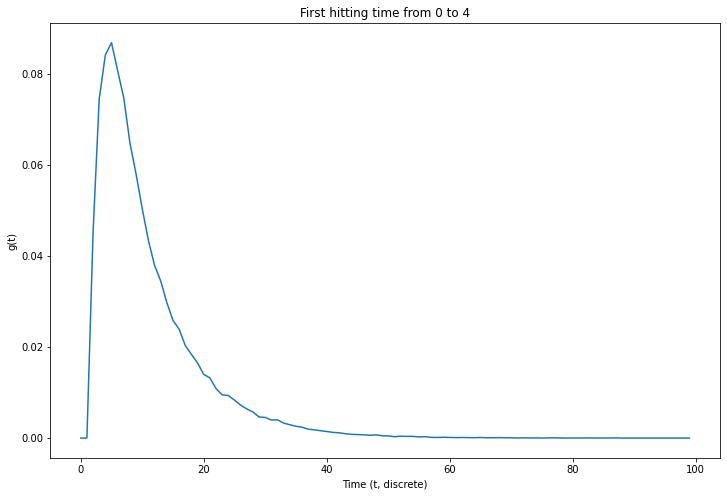

In [37]:
def plot_g(p=0.3, q=0.1, from_m=0, to_m=4, max_steps=100, n_simulations=10**5):
    P = get_P(p, q)

    Hs = [ simulate_H(from_m=from_m, to_m=to_m, P=P, steps=max_steps) for _ in range(n_simulations) ]
    counted = defaultdict(int, dict(Counter(Hs)))
    y = np.array([ counted[i] for i in range(max_steps) ]) / n_simulations
    
    plt.figure(figsize=(12, 8))
    plt.plot(list(range(max_steps)), y)
    plt.xlabel('Time (t, discrete)')
    plt.ylabel('g(t)')
    plt.title('First hitting time from 0 to 4')
    plt.show()

plot_g()

Por un lado, merece la pena comentar el pequeño delay inicial: ninguna ejecución llega al estado $4$ en menos de dos instantes. Mirando el grafo de nuestra cadena, este resultado es obvio: el menor camino de $0$ a $4$ tiene longitud $2$. Conforme el tiempo aumenta, la mayoría de caminantes aleatorios que estaban todavía en los estados $0$, $1$ y $2$ acaban llegando al conjunto $\{3,4\}$, terminando en su mayoría en dicho estado.

Recordemos que por la configuración de nuestra cadena, siempre podemos tardar un tiempo arbitrariamente alto en alcanzar este estado, aunque la probabilidad sea muy pequeña.

Por otro lado, merece la pena comentar que no observamos ningún tipo de periodicidad en esta gráfica. Por ejemplo, si nos encontrásemos ante un gráfico bipartido, únicamente podríamos llegar a cada estado en los tiempos pares o impares, pero no en ambos. Si nos encontrásemos antes un grafo tripartido, sólo podríamos llegar cada 3 tiempos. Este no es el caso en nuestra cadena.

<div class="exercise">

$vi)$ Razonar si $H_0^{\{4\}} < H_0^{\{5\}}$.
</div>

En efecto. Intuitivamente este resultado es obvio: no podemos llegar al nodo $5$ sin pasar por el $4$, así que el tiempo mínimo de llegada al nodo $5$ siempre será 1 instante superior.

<h1>Resultados adicionales</h1>

Enunciamos a continuación una serie de resultados asociados a la teoría de cadenas de Markov que puede ayudarnos a ganar intuición.

Sean $C_1, C_2$ dos clases comunicantes. Si existen un camino de $C_1$ a $C_2$ y viceversa, entonces son la misma clase de Markov. Esto nos indica que la cadena reducida en la que representamos únicamente las clases comunicantes ha de ser un árbol.

Si colocamos los nodos raíz del árbol -aquellos a los que no llega ninguna arista del grafo- en la parte superior del diagrama y pintamos todos los enlaces hacia abajo en una estructura "de cascada" los siguientes resultados se vuelven muy intuitivos:

- Las clases cerradas son aquellas situadas en la parte inferior de dicha cascada, aquellas de las que no sale ninguna arista.
- Las clases abiertas son las superiores, de las que salen aristas. Con esta visión en mente es sencillo darse cuenta de que \textbf{una clase es transitiva si y sólo si es abierta}.
- Si hay posibles estados ($|M| \ \infty$), puede haber infinitas clases abiertas y/o cerradas. Puede incluso no haber ninguna clase cerrada. Además, una cerrada y finita siempre será recurrente, pero el recíproco no es cierto como vimos en clase.
- Si hay únicamente una clase comunicante, la cadena es irredubile, y dicha clase será cerrada. De nuevo, si es finita será también recurrente pero el recíproco no podemos asegurarlo. Este es el caso de nuestro grafo si $q=0.1$: la cadena es irreducible y finita. Por lo tanto, $h_m^n = 1$ sin necesidad de hacer ninguna cuenta adicional.
- El caso que estudiaremos con mayor frecuencia es el de una cadena finita con más de una clase. En este caso \textbf{siempre podemos asegurar la existencia de una clase cerrada y recurrente}: Si no la hubiese, habría un ciclo en el grafo y la cadena sería irreducible. Además, si la cadena es conexa habrá también al menos una cadena abierta.
